# POS Tagging in Job Descriptions

## Objective
The goal of this notebook is to perform **Part-of-Speech (POS) tagging** 
on job descriptions and analyze the grammatical structures
 used in **real**, **fake**, and **AI-generated** job postings.

By tagging and analyzing the roles of words in each job post
 (e.g., noun, verb, adjective), we can detect repetitive patterns, 
 unnatural syntax, or overly structured sentences, especially in AI-written or scam posts.

---

### Why POS Tagging?

- **AI-generated** posts may sound too robotic or clean.
- **Fake** posts may use specific persuasive language patterns.
- **Real** posts may have a more natural tone.


In [ ]:
# Text and NLP
import nltk
import re
import string
from nltk.corpus import stopwords
from collections import Counter

# Data handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Download required NLTK packages
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Important: keep_default_na=False to treat empty strings properly

# Load your cleaned data
real_jobs = pd.read_csv(
    "../1_datasets/cleaned_data/real_jobs.csv", keep_default_na=False
)
human_fake_jobs = pd.read_csv(
    "../1_datasets/cleaned_data/fake_jobs.csv", keep_default_na=False
)
ai_fake_jobs = pd.read_csv(
    "../1_datasets/cleaned_data/llm_refined_fake_posts2.csv",
    keep_default_na=False,
)

# Ensure all text columns are strings
text_columns = ["description", "requirements", "benefits"]
for col in text_columns:
    real_jobs[col] = real_jobs[col].astype(str)
    human_fake_jobs[col] = human_fake_jobs[col].astype(str)
    ai_fake_jobs[col] = ai_fake_jobs[col].astype(str)

# Label the datasets
real_jobs["label"] = "real"
human_fake_jobs["label"] = "human_fake"
ai_fake_jobs["label"] = "ai_fake"

# Combine into one DataFrame
data = pd.concat([real_jobs, human_fake_jobs, ai_fake_jobs], ignore_index=True)

# Preview sample data
data[["label", "description", "requirements"]].sample(3)

,label,description,requirements
6986,real,JOB DESCRIPTIONMark Edwards Group is a leading...,KEY REQUIREMENTS• College or University deg...
6186,real,"Play with kids, get paid for it :-)Love travel...",University degree required. TEFL / TESOL / CEL...
9538,real,UnoTelly is a DNS &amp; VPN service that allow...,Minimum 5 years of system and networking exper...


In [ ]:
# Explicitly set the download directory
nltk.download("punkt", download_dir="nltk_data")
nltk.data.path.append("nltk_data")

[nltk_data] Downloading package punkt to nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Define the text cleaning function
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return " ".join(
        [word for word in text.split() if word not in stop_words]
    )  # Remove stopwords


# Drop rows where description or requirements are empty or NaN
data = data[
    (data["description"].notna())
    & (data["requirements"].notna())
    & (data["description"].str.strip() != "")
    & (data["requirements"].str.strip() != "")
]

# Clean both columns
data["clean_description"] = data["description"].apply(clean_text)
data["clean_requirements"] = data["requirements"].apply(clean_text)

# ✅ Now preview, after columns exist
data[["label", "clean_description", "clean_requirements"]].sample(3)

# Tokenize using split
data["desc_tokens"] = data["clean_description"].apply(lambda x: x.split())
data["req_tokens"] = data["clean_requirements"].apply(lambda x: x.split())

# ✅ Final preview
data[["label", "desc_tokens", "req_tokens"]].sample(3)

,label,desc_tokens,req_tokens
7299,real,"[new, vp, sales, responsible, expanding, flite...","[ideal, candidate, havevice, presidentlevel, e..."
16504,real,"[local, company, looking, energetic, fulltime,...","[experience, yearsskills, ship, high, volume, ..."
10219,real,"[dice, highly, specialized, online, marketing,...","[right, candidate, must, smart, honest, techsa..."


---

## POS Tagging

POS tagging labels each word with its grammatical role -
such as nouns (`NN`), verbs (`VB`), adjectives (`JJ`), etc. 
This can help us spot unnatural or formulaic grammar in AI-generated 
or scam job posts.


In [5]:
# Simple rule-based POS tagging approximation
def simple_pos_tag(tokens):
    pos_tags = []
    for word in tokens:
        if word.endswith("ing") or word in [
            "manage",
            "develop",
            "work",
            "create",
        ]:
            pos_tags.append((word, "VB"))  # Verb
        elif word.endswith("ly") or word in ["quickly", "efficiently"]:
            pos_tags.append((word, "RB"))  # Adverb
        elif word.endswith("ed"):
            pos_tags.append((word, "VBD"))  # Past tense verb
        elif word in ["the", "a", "an"]:
            pos_tags.append((word, "DT"))  # Determiner
        elif word.endswith("ion") or word in [
            "team",
            "experience",
            "development",
        ]:
            pos_tags.append((word, "NN"))  # Noun
        elif (
            word.endswith("ive")
            or word.endswith("ous")
            or word in ["strong", "excellent"]
        ):
            pos_tags.append((word, "JJ"))  # Adjective
        else:
            pos_tags.append((word, "UNK"))  # Unknown
    return pos_tags


# Apply to both description and requirements tokens
data["desc_pos"] = data["desc_tokens"].apply(simple_pos_tag)
data["req_pos"] = data["req_tokens"].apply(simple_pos_tag)

# Preview
data[["label", "desc_pos", "req_pos"]].sample(2)

,label,desc_pos,req_pos
1997,real,"[(alliance, UNK), (manager, UNK), (proven, UNK...","[(knowledge, UNK), (skills, UNK), (experiencea..."
13105,real,"[(unique, UNK), (job, UNK), (great, UNK), (com...","[(years, UNK), (applicable, UNK), (work, VB), ..."


In [ ]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to C:\Users\DELL/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## POS Tag Frequency Visualization

Now that we’ve tagged parts of speech (POS) using a rule-based approach,
 we’ll count the frequency of each POS tag per job type. 
 This helps us understand whether AI-written or human-written fake 
 job posts use different grammatical structures than real ones.


<Figure size 1000x600 with 0 Axes>

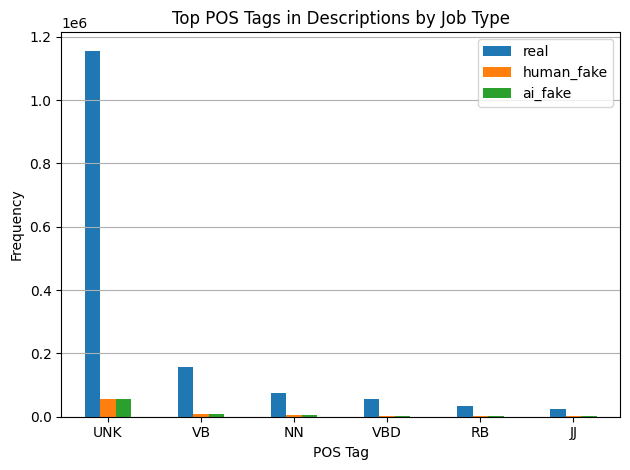

In [ ]:
# Flatten all POS tags per label
def extract_pos_counts(df, pos_col, label_col):
    pos_by_label = {"real": [], "human_fake": [], "ai_fake": []}

    for label in df[label_col].unique():
        all_tags = [
            tag
            for row in df[df[label_col] == label][pos_col]
            for _, tag in row
        ]
        pos_by_label[label] = Counter(all_tags)

    return pos_by_label


# Get POS tag counts
pos_counts = extract_pos_counts(data, "desc_pos", "label")

# Convert to DataFrame for visualization
pos_df = pd.DataFrame(pos_counts).fillna(0).astype(int)
pos_df = pos_df.sort_values(by="real", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
pos_df.head(10).plot(kind="bar")
plt.title("Top POS Tags in Descriptions by Job Type")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [8]:
# Flatten all POS tags per label
pos_tables = {}
labels = data["label"].unique()

for label in labels:
    tagged = data[data["label"] == label]["desc_pos"].explode()
    pos_tags = [tag for _, tag in tagged if tag != "UNK"]
    pos_tables[label] = Counter(pos_tags)

# Convert to DataFrame
pos_df = pd.DataFrame(pos_tables).fillna(0).astype(int)

# Display the top 10 POS tags by total frequency
top_tags = pos_df.sum(axis=1).sort_values(ascending=False).head(10).index
pos_df_top = pos_df.loc[top_tags]

pos_df_top

,real,human_fake,ai_fake
VB,155642,7135,7135
NN,74056,4076,4076
VBD,54899,2600,2600
RB,33738,1518,1518
JJ,25847,1049,1049


### POS Tag Frequency in Job Descriptions

This bar chart shows the **Top POS (Part-of-Speech) tags** found in job 
descriptions across three categories: **real**, **human-written fake**, and 
**AI-generated fake** postings.

#### Key POS Tags:
- **UNK**: Unknown tags – likely due to improper tokenization or 
  rare/unrecognized words.
- **VB**: Base form of verb (e.g., "develop", "create").
- **NN**: Noun, singular (e.g., "developer", "experience").
- **VBD**: Verb, past tense (e.g., "developed").
- **RB**: Adverb (e.g., "quickly").
- **JJ**: Adjective (e.g., "innovative").

---

### Observations:

1. **UNK dominates** in the `real` job descriptions — this may indicate a 
   tokenization mismatch or many uncommon words not tagged correctly. 
   Consider debugging or filtering out "UNK" tags for clearer results.

2. **VB (base verbs)** are more frequent in real jobs than in fake ones. 
   This suggests real job descriptions focus more on actionable tasks.

3. **NN (nouns)** and **JJ (adjectives)** show smaller but consistent usage 
   across all job types, indicating shared grammatical structure.

4. **AI-generated** and **human-fake** descriptions have fewer POS tags 
   overall — possibly reflecting simpler or shorter sentence structures.

5. The use of **VBD** and **RB** is low across the board, which aligns with 
   the fact that job descriptions are typically written in the present or 
   imperative form.

---

These patterns may help differentiate between job types in future 
classification models or linguistic analysis.
